In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate,StratifiedKFold,GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [3]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [4]:
df = df[5::6] #TO Show every other hour

In [ ]:
# df[5::12]

In [5]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:10:00,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
2016-12-31 20:10:00,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
2016-12-31 21:10:00,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7


<Axes: xlabel='Date Time'>

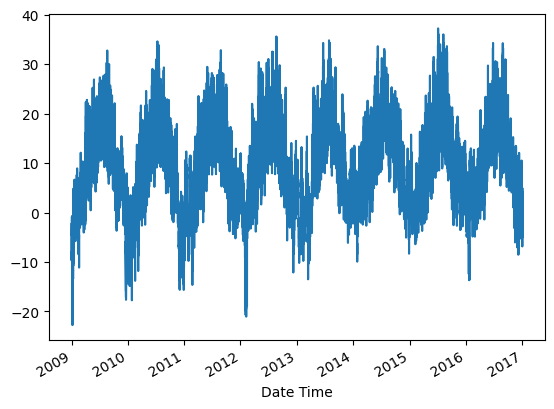

In [6]:
temp = df['T (degC)']
temp.plot()

In [7]:
def create_dataset_bystep(df, step = 5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-step):
    row = [[a] for a in df_as_np[i:i+step]]# the [a] 3lshan n5aly el array msln lw el step 5 el x tb2a[[[1], [2], [3], [4], [5]] w el y msh azma htappend ka vector
    X.append(row)
    label = df_as_np[i+step]
    y.append(label)
  return np.array(X), np.array(y)

In [8]:
steps = 5 # e5tarna 5 steps 3lshan mn el 5 sa3at ely ablyha ypredict el sa3a el 6
X1, y1 = create_dataset_bystep(temp, steps)#temp 3lshan awk3 wa7da 7alyen
X1.shape, y1.shape

((70086, 5, 1), (70086,))

In [9]:
train_size = 65000


X_train1, y_train1 = X1[:train_size], y1[:train_size]
X_test1, y_test1 = X1[train_size:], y1[train_size:]

print("X_train1 shape:", X_train1.shape)
print("y_train1 shape:", y_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("y_test1 shape:", y_test1.shape)

X_train1 shape: (65000, 5, 1)
y_train1 shape: (65000,)
X_test1 shape: (5086, 5, 1)
y_test1 shape: (5086,)


# Uni-variate

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
cp1 = ModelCheckpoint('/content/model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [12]:
model1.fit(X_train1, y_train1, epochs=10, callbacks=[cp1])

Epoch 1/10
2032/2032 [==============================] - ETA: 0s - loss: 28.0061 - root_mean_squared_error: 5.2921

2032/2032 [==============================] - 13s 5ms/step - loss: 28.0061 - root_mean_squared_error: 5.2921
Epoch 2/10
2031/2032 [============================>.] - ETA: 0s - loss: 1.7966 - root_mean_squared_error: 1.3404

2032/2032 [==============================] - 9s 4ms/step - loss: 1.7966 - root_mean_squared_error: 1.3404
Epoch 3/10
2024/2032 [============================>.] - ETA: 0s - loss: 0.8571 - root_mean_squared_error: 0.9258

2032/2032 [==============================] - 10s 5ms/step - loss: 0.8568 - root_mean_squared_error: 0.9256
Epoch 4/10
2029/2032 [============================>.] - ETA: 0s - loss: 0.7066 - root_mean_squared_error: 0.8406

2032/2032 [==============================] - 12s 6ms/step - loss: 0.7067 - root_mean_squared_error: 0.8407
Epoch 5/10
2024/2032 [============================>.] - ETA: 0s - loss: 0.6673 - root_mean_squared_error: 0.8169

2032/2032 [==============================] - 15s 7ms/step - loss: 0.6664 - root_mean_squared_error: 0.8163
Epoch 6/10
2028/2032 [============================>.] - ETA: 0s - loss: 0.6524 - root_mean_squared_error: 0.8077

2032/2032 [==============================] - 9s 4ms/step - loss: 0.6525 - root_mean_squared_error: 0.8078
Epoch 7/10
2029/2032 [============================>.] - ETA: 0s - loss: 0.6469 - root_mean_squared_error: 0.8043

2032/2032 [==============================] - 9s 4ms/step - loss: 0.6470 - root_mean_squared_error: 0.8044
Epoch 8/10
2026/2032 [============================>.] - ETA: 0s - loss: 0.6431 - root_mean_squared_error: 0.8019

2032/2032 [==============================] - 9s 5ms/step - loss: 0.6426 - root_mean_squared_error: 0.8016
Epoch 9/10
2027/2032 [============================>.] - ETA: 0s - loss: 0.6373 - root_mean_squared_error: 0.7983

2032/2032 [==============================] - 9s 4ms/step - loss: 0.6376 - root_mean_squared_error: 0.7985
Epoch 10/10
2023/2032 [============================>.] - ETA: 0s - loss: 0.6358 - root_mean_squared_error: 0.7974

2032/2032 [==============================] - 9s 4ms/step - loss: 0.6359 - root_mean_squared_error: 0.7975


In [13]:
from tensorflow.keras.models import load_model
lstmUni = load_model('/content/model1')

OSError: SavedModel file does not exist at: /content/model1/{saved_model.pbtxt|saved_model.pb}

In [14]:
train_predictions = model1.predict(X_train1).flatten()#3amlna flatten 3lshan tb2a 1D badel makanet matrix fo2 w tb2a aligned ma3 el actual 3lshan nee3rf ncompare
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

2032/2032 [==============================] - 4s 2ms/step


,Train Predictions,Actuals
0,-9.827973,-9.67
1,-9.679708,-9.17
2,-8.781242,-8.10
3,-7.291923,-7.66
4,-7.161829,-7.04
...,...,...
64995,17.324814,18.27
64996,17.451033,17.85
64997,17.302935,16.65
64998,15.948794,15.85


In [15]:
# plt.figure(figsize=(10, 6))
# plt.plot(train_results.index, train_results['Train Predictions'], label='Train Predictions')
# plt.plot(train_results.index, train_results['Actuals'], label='Actuals')
# plt.xlabel('Sample Index')
# plt.ylabel('Value')
# plt.title('Training Predictions vs Actuals')
# plt.legend()
# plt.show()

Text(0.5, 1.0, 'Training Predictions vs Actuals between the indeces of 50 and 100')

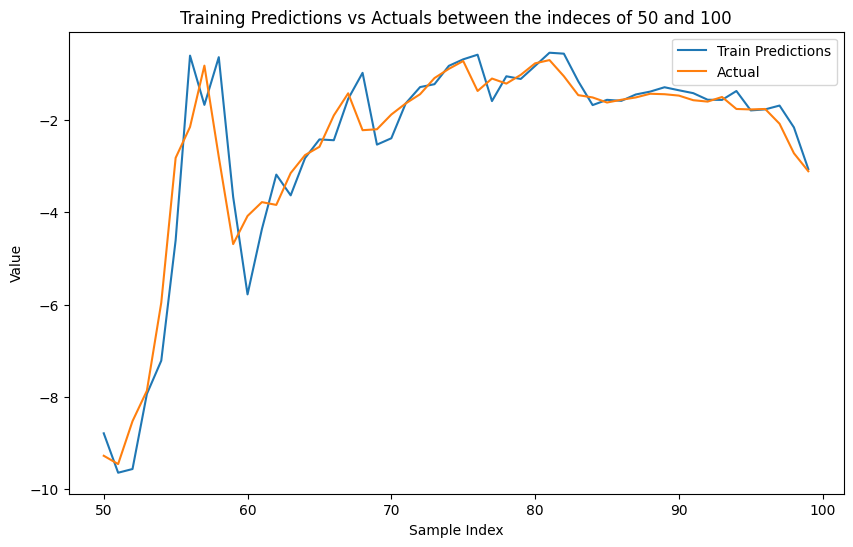

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(train_results['Train Predictions'][50:100] , label = 'Train Predictions')
plt.plot(train_results['Actuals'][50:100],label = 'Actual')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.title('Training Predictions vs Actuals between the indeces of 50 and 100')

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

# Assuming you have the ground truth values in y_train1 and the predicted values in train_predictions

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_train1, train_predictions)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_train1, train_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_train1, train_predictions)
print("This is based on the train and actual")
print("Mean Absolute Error (MAE): ", mae)
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)
print("Mean Absolute Percentage Error (MAPE): ", mape)

This is based on the train and actual
Mean Absolute Error (MAE):  0.5335396865626757
Mean Squared Error (MSE):  0.6281567049926905
Root Mean Squared Error (RMSE):  0.792563376010203
Mean Absolute Percentage Error (MAPE):  19.78620992790643


In [18]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

159/159 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,14.513749,13.99
1,13.354624,13.46
2,12.971958,12.93
3,12.582093,12.43
4,12.121653,12.17
...,...,...
5081,-1.084671,-0.98
5082,-1.473657,-1.40
5083,-1.710797,-2.75
5084,-3.213014,-2.89


Text(0.5, 1.0, 'Test Predictions vs Actuals for the indeces of the last 100')

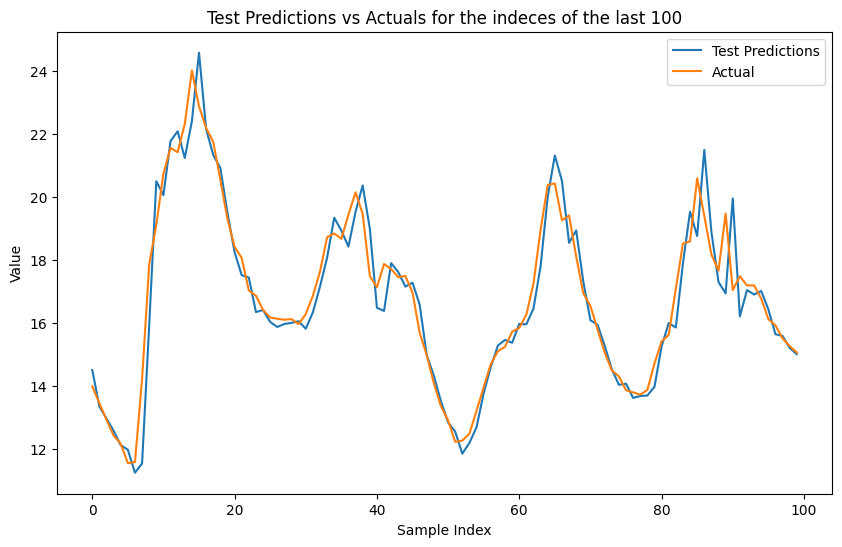

In [19]:
# plt.plot(val_results['Val Predictions'][:100])
# plt.plot(val_results['Actuals'][:100])
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(test_results['Test Predictions'][:100] , label = 'Test Predictions')
plt.plot(test_results['Actuals'][:100],label = 'Actual')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()

plt.title('Test Predictions vs Actuals for the indeces of the last 100')

In [20]:
# evaluation_metrics = model1.evaluate(X_train1, y_train1)

# print("Evaluation Metrics:")
# for metric_name, metric_value in zip(model1.metrics_names, evaluation_metrics):
#     print(metric_name + ": ", metric_value)

In [21]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)

# Assuming you have the ground truth values in y_test1 and the predicted values in test_predictions
evaluate_model(y_test1, test_predictions)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.5342756342978704
Mean Squared Error (MSE):  0.6102722793509743
Root Mean Squared Error (RMSE):  0.7811992571367271
Mean Absolute Percentage Error (MAPE):  12.050397513403018


# CNN

In [ ]:
CNN = Sequential()
CNN.add(InputLayer((5, 1)))
CNN.add(Conv1D(64, kernel_size=2))
CNN.add(Flatten())
CNN.add(Dense(8, 'relu'))
CNN.add(Dense(1, 'linear'))

CNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 2056      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('CNN/', save_best_only=True)
CNN.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
CNN.fit(X_train1, y_train1, epochs=10, callbacks=[cp2])

Epoch 1/10
2032/2032 [==============================] - ETA: 0s - loss: 8.4343 - root_mean_squared_error: 2.9042

2032/2032 [==============================] - 9s 4ms/step - loss: 8.4343 - root_mean_squared_error: 2.9042
Epoch 2/10
2022/2032 [============================>.] - ETA: 0s - loss: 1.3984 - root_mean_squared_error: 1.1826

2032/2032 [==============================] - 7s 3ms/step - loss: 1.3971 - root_mean_squared_error: 1.1820
Epoch 3/10
2030/2032 [============================>.] - ETA: 0s - loss: 0.7968 - root_mean_squared_error: 0.8927

2032/2032 [==============================] - 8s 4ms/step - loss: 0.7970 - root_mean_squared_error: 0.8928
Epoch 4/10
2029/2032 [============================>.] - ETA: 0s - loss: 0.6838 - root_mean_squared_error: 0.8269

2032/2032 [==============================] - 7s 4ms/step - loss: 0.6836 - root_mean_squared_error: 0.8268
Epoch 5/10
2030/2032 [============================>.] - ETA: 0s - loss: 0.6712 - root_mean_squared_error: 0.8193

2032/2032 [==============================] - 8s 4ms/step - loss: 0.6710 - root_mean_squared_error: 0.8191
Epoch 6/10
2031/2032 [============================>.] - ETA: 0s - loss: 0.6680 - root_mean_squared_error: 0.8173

2032/2032 [==============================] - 7s 4ms/step - loss: 0.6679 - root_mean_squared_error: 0.8173
Epoch 7/10
2022/2032 [============================>.] - ETA: 0s - loss: 0.6672 - root_mean_squared_error: 0.8168

2032/2032 [==============================] - 7s 3ms/step - loss: 0.6669 - root_mean_squared_error: 0.8166
Epoch 8/10
2020/2032 [============================>.] - ETA: 0s - loss: 0.6628 - root_mean_squared_error: 0.8141

2032/2032 [==============================] - 8s 4ms/step - loss: 0.6630 - root_mean_squared_error: 0.8143
Epoch 9/10
2019/2032 [============================>.] - ETA: 0s - loss: 0.6513 - root_mean_squared_error: 0.8070

2032/2032 [==============================] - 7s 3ms/step - loss: 0.6508 - root_mean_squared_error: 0.8067
Epoch 10/10
2026/2032 [============================>.] - ETA: 0s - loss: 0.6469 - root_mean_squared_error: 0.8043

2032/2032 [==============================] - 8s 4ms/step - loss: 0.6471 - root_mean_squared_error: 0.8044


In [ ]:
cnn_test_predictions = CNN.predict(X_test1).flatten()
cnn_test_results = pd.DataFrame(data={'Test Predictions':cnn_test_predictions, 'Actuals':y_test1})
cnn_test_results

159/159 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,14.444778,13.99
1,13.269385,13.46
2,12.948810,12.93
3,12.525373,12.43
4,12.088511,12.17
...,...,...
5081,-1.084860,-0.98
5082,-1.315994,-1.40
5083,-1.606624,-2.75
5084,-3.190921,-2.89


In [ ]:
evaluate_model(y_test1, cnn_test_predictions)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.5410969202717341
Mean Squared Error (MSE):  0.638206618313746
Root Mean Squared Error (RMSE):  0.7988783501345784
Mean Absolute Percentage Error (MAPE):  12.696869421087827


Text(0.5, 1.0, 'Test Predictions vs Actuals for the indeces of the last 100')

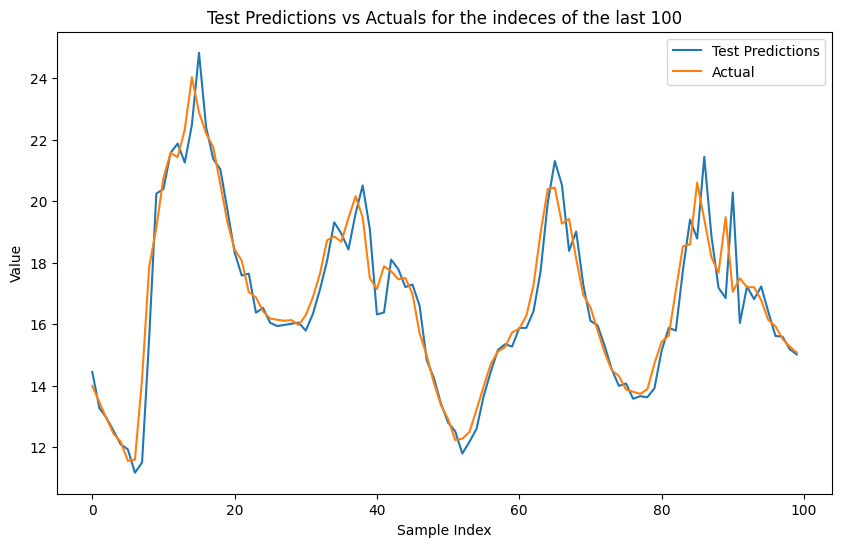

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(cnn_test_results['Test Predictions'][:100] , label = 'Test Predictions')
plt.plot(cnn_test_results['Actuals'][:100],label = 'Actual')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()

plt.title('Test Predictions vs Actuals for the indeces of the last 100')

# GRU

In [ ]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp3 = ModelCheckpoint('GRU/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(X_train1, y_train1, epochs=10, callbacks=[cp3])

Epoch 1/10
2024/2032 [============================>.] - ETA: 0s - loss: 52.4856 - root_mean_squared_error: 7.2447

2032/2032 [==============================] - 12s 5ms/step - loss: 52.3357 - root_mean_squared_error: 7.2343
Epoch 2/10
2024/2032 [============================>.] - ETA: 0s - loss: 3.9310 - root_mean_squared_error: 1.9827

2032/2032 [==============================] - 10s 5ms/step - loss: 3.9257 - root_mean_squared_error: 1.9813
Epoch 3/10
2025/2032 [============================>.] - ETA: 0s - loss: 1.1707 - root_mean_squared_error: 1.0820

2032/2032 [==============================] - 10s 5ms/step - loss: 1.1693 - root_mean_squared_error: 1.0814
Epoch 4/10
2023/2032 [============================>.] - ETA: 0s - loss: 0.7568 - root_mean_squared_error: 0.8700

2032/2032 [==============================] - 10s 5ms/step - loss: 0.7571 - root_mean_squared_error: 0.8701
Epoch 5/10
2022/2032 [============================>.] - ETA: 0s - loss: 0.6683 - root_mean_squared_error: 0.8175

2032/2032 [==============================] - 10s 5ms/step - loss: 0.6685 - root_mean_squared_error: 0.8176
Epoch 6/10
2026/2032 [============================>.] - ETA: 0s - loss: 0.6464 - root_mean_squared_error: 0.8040

2032/2032 [==============================] - 10s 5ms/step - loss: 0.6460 - root_mean_squared_error: 0.8038
Epoch 7/10
2029/2032 [============================>.] - ETA: 0s - loss: 0.6376 - root_mean_squared_error: 0.7985

2032/2032 [==============================] - 10s 5ms/step - loss: 0.6374 - root_mean_squared_error: 0.7983
Epoch 8/10
2027/2032 [============================>.] - ETA: 0s - loss: 0.6336 - root_mean_squared_error: 0.7960

2032/2032 [==============================] - 10s 5ms/step - loss: 0.6333 - root_mean_squared_error: 0.7958
Epoch 9/10
2024/2032 [============================>.] - ETA: 0s - loss: 0.6292 - root_mean_squared_error: 0.7932

2032/2032 [==============================] - 10s 5ms/step - loss: 0.6295 - root_mean_squared_error: 0.7934
Epoch 10/10
2026/2032 [============================>.] - ETA: 0s - loss: 0.6276 - root_mean_squared_error: 0.7922

2032/2032 [==============================] - 9s 4ms/step - loss: 0.6276 - root_mean_squared_error: 0.7922


TCN

In [24]:
pip install keras-tcn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


In [25]:
from tcn import TCN
TCN_model = Sequential()
TCN_model.add(InputLayer((5, 1)))
TCN_model.add(TCN(64, kernel_size=2, dilations=[1, 2, 4, 8]))
TCN_model.add(Dense(8, activation='relu'))
TCN_model.add(Dense(1, activation='linear'))

TCN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 64)                58112     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 58641 (229.07 KB)
Trainable params: 58641 (229.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
cp4 = ModelCheckpoint('Tcn/', save_best_only=True)
TCN_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [27]:
TCN_model.fit(X_train1, y_train1, epochs=10, callbacks=[cp4])

Epoch 1/10
2032/2032 [==============================] - ETA: 0s - loss: 3.7922 - root_mean_squared_error: 1.9474

2032/2032 [==============================] - 23s 8ms/step - loss: 3.7922 - root_mean_squared_error: 1.9474
Epoch 2/10
2026/2032 [============================>.] - ETA: 0s - loss: 0.7546 - root_mean_squared_error: 0.8687

2032/2032 [==============================] - 15s 7ms/step - loss: 0.7539 - root_mean_squared_error: 0.8682
Epoch 3/10
2032/2032 [==============================] - ETA: 0s - loss: 0.7538 - root_mean_squared_error: 0.8682

2032/2032 [==============================] - 16s 8ms/step - loss: 0.7538 - root_mean_squared_error: 0.8682
Epoch 4/10
2030/2032 [============================>.] - ETA: 0s - loss: 0.7358 - root_mean_squared_error: 0.8578

2032/2032 [==============================] - 29s 14ms/step - loss: 0.7357 - root_mean_squared_error: 0.8577
Epoch 5/10
2026/2032 [============================>.] - ETA: 0s - loss: 0.7386 - root_mean_squared_error: 0.8594

2032/2032 [==============================] - 19s 9ms/step - loss: 0.7384 - root_mean_squared_error: 0.8593
Epoch 6/10
2030/2032 [============================>.] - ETA: 0s - loss: 0.7316 - root_mean_squared_error: 0.8553

2032/2032 [==============================] - 15s 8ms/step - loss: 0.7315 - root_mean_squared_error: 0.8553
Epoch 7/10
2031/2032 [============================>.] - ETA: 0s - loss: 0.7180 - root_mean_squared_error: 0.8473

2032/2032 [==============================] - 17s 9ms/step - loss: 0.7182 - root_mean_squared_error: 0.8475
Epoch 8/10
2031/2032 [============================>.] - ETA: 0s - loss: 0.7095 - root_mean_squared_error: 0.8423

2032/2032 [==============================] - 19s 10ms/step - loss: 0.7095 - root_mean_squared_error: 0.8423
Epoch 9/10
2031/2032 [============================>.] - ETA: 0s - loss: 0.6967 - root_mean_squared_error: 0.8347

2032/2032 [==============================] - 15s 7ms/step - loss: 0.6967 - root_mean_squared_error: 0.8347
Epoch 10/10
2030/2032 [============================>.] - ETA: 0s - loss: 0.6943 - root_mean_squared_error: 0.8333

2032/2032 [==============================] - 16s 8ms/step - loss: 0.6943 - root_mean_squared_error: 0.8333


In [31]:
tcn_test_predictions = TCN_model.predict(X_test1).flatten()
tcn_test_results = pd.DataFrame(data={'Test Predictions':tcn_test_predictions, 'Actuals':y_test1})
tcn_test_results

159/159 [==============================] - 1s 5ms/step


,Test Predictions,Actuals
0,14.820597,13.99
1,13.760054,13.46
2,13.304161,12.93
3,12.778479,12.43
4,12.359011,12.17
...,...,...
5081,-1.342054,-0.98
5082,-1.682050,-1.40
5083,-1.794615,-2.75
5084,-3.168547,-2.89


In [32]:
evaluate_model(y_test1, tcn_test_predictions)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.5759376465021756
Mean Squared Error (MSE):  0.680531588429378
Root Mean Squared Error (RMSE):  0.824943384984314
Mean Absolute Percentage Error (MAPE):  13.871543536910572


# Multi Variate

In [ ]:
# temp_df = pd.DataFrame({'Temperature':temp})
# temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
# temp_df

In [ ]:
# day = 60*60*24
# year = 365.2425*day

# temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
# temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
# temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
# temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
# temp_df.head()

In [ ]:
# temp_df = temp_df.drop('Seconds', axis=1)
# temp_df.head()

[==================================================] 13827694 bytes downloaded
Downloaded and uncompressed: jena-climate
Data source import complete.


In [ ]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-14 06:20:00,14.05.2010 06:20:00,983.50,6.24,280.73,4.34,87.6,9.51,8.33,1.18,5.29,8.47,1222.33,1.81,3.40,19.32
2010-05-14 07:20:00,14.05.2010 07:20:00,983.66,6.30,280.78,4.32,87.1,9.56,8.32,1.23,5.28,8.46,1222.24,2.25,3.48,26.83
2010-05-14 08:20:00,14.05.2010 08:20:00,983.70,6.65,281.13,4.21,84.4,9.79,8.26,1.53,5.24,8.40,1220.82,1.57,2.92,10.44


In [33]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df['Date Time']=pd.to_datetime(df['Date Time'],format='mixed')

df= df[df['Date Time'].dt.minute==0].reset_index(drop=True).drop(columns=['Tpot (K)','Tdew (degC)'])
df.head()

,Date Time,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [34]:
input_= df[[i for i in df.columns if i not in ['Date Time']]]
target = df['T (degC)'].to_numpy()

X, X_test, y, y_test = train_test_split(input_, target, test_size=0.1, shuffle=False, random_state=2024)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False, random_state=2024)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(53619, 12) (9463, 12) (7010, 12)
(53619,) (9463,) (7010,)


In [35]:
# scaling data
preprocessing= ColumnTransformer([
    ('pipe',make_pipeline(StandardScaler()), list(input_.columns))
    ])

X_train_scaled = preprocessing.fit_transform(X_train)
X_val_scaled = preprocessing.transform(X_val)
X_test_scaled = preprocessing.transform(X_test)

In [36]:
window_len = 24
batch_size = 16
train_gen = TimeseriesGenerator(data=X_train_scaled, targets=y_train, length=window_len, shuffle=False, batch_size=batch_size)
val_gen = TimeseriesGenerator(data=X_val_scaled, targets=y_val, length=window_len, shuffle=False, batch_size=batch_size)
test_gen=TimeseriesGenerator(data=X_test_scaled, targets=y_test, length=window_len, shuffle=False, batch_size=batch_size)


,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.50,-8.05,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
1,996.62,-8.88,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
2,996.84,-8.81,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
3,996.99,-9.05,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
4,997.46,-9.63,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...
63077,1000.67,2.93,88.0,7.54,6.64,0.90,4.13,6.63,1259.47,3.14,5.33,27.15
63078,1000.91,2.29,91.3,7.21,6.58,0.63,4.10,6.57,1262.71,4.25,5.61,41.94
63079,1001.13,2.48,91.1,7.31,6.66,0.65,4.15,6.65,1262.05,3.49,4.49,28.55
63080,1001.52,2.77,90.2,7.46,6.73,0.73,4.19,6.72,1261.22,2.44,3.45,42.99


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(window_len, len(input_.columns)), return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dense(1))

num_epochs = 10
num_train_steps = len(train_gen) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
              metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 24, 256)           275456    
                                                                 
 re_lu_4 (ReLU)              (None, 24, 256)           0         
                                                                 
 lstm_8 (LSTM)               (None, 24, 128)           197120    
                                                                 
 re_lu_5 (ReLU)              (None, 24, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 522049 (1.99 MB)
Trainable params: 52204

In [ ]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)

model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/10
3350/3350 [==============================] - 41s 11ms/step - loss: 36.2012 - root_mean_squared_error: 6.0167 - val_loss: 125.3566 - val_root_mean_squared_error: 11.1963
Epoch 2/10
3350/3350 [==============================] - 35s 10ms/step - loss: 7.6968 - root_mean_squared_error: 2.7743 - val_loss: 3.2874 - val_root_mean_squared_error: 1.8131
Epoch 3/10
3350/3350 [==============================] - 34s 10ms/step - loss: 1.1398 - root_mean_squared_error: 1.0676 - val_loss: 1.3608 - val_root_mean_squared_error: 1.1665
Epoch 4/10
3350/3350 [==============================] - 36s 11ms/step - loss: 0.8246 - root_mean_squared_error: 0.9081 - val_loss: 1.5356 - val_root_mean_squared_error: 1.2392
Epoch 5/10
3350/3350 [==============================] - 34s 10ms/step - loss: 0.7673 - root_mean_squared_error: 0.8760 - val_loss: 0.9744 - val_root_mean_squared_error: 0.9871
Epoch 6/10
3350/3350 [==============================] - 37s 11ms/step - loss: 0.6545 - root_mean_squared_error: 0.80

In [ ]:
# save model
model.save('multi_lstm_temperature.h5')

# load model
new_model = tf.keras.models.load_model('multi_lstm_temperature.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pred = new_model.predict(test_gen).flatten()

437/437 [==============================] - 3s 4ms/step


In [ ]:
df_result = X_test[window_len:].copy()
df_result['pred'] =  pred
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time','T (degC)','pred']].set_axis(['Date Time', 'Temperature', 'Prediction'],axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63106,2016-12-03 21:00:00,0.87,0.974616
63107,2016-12-03 22:00:00,0.88,0.870462
63108,2016-12-03 23:00:00,0.93,0.928012
63109,2016-03-13 00:00:00,1.07,1.046469
63110,2016-03-13 01:00:00,1.07,1.237715


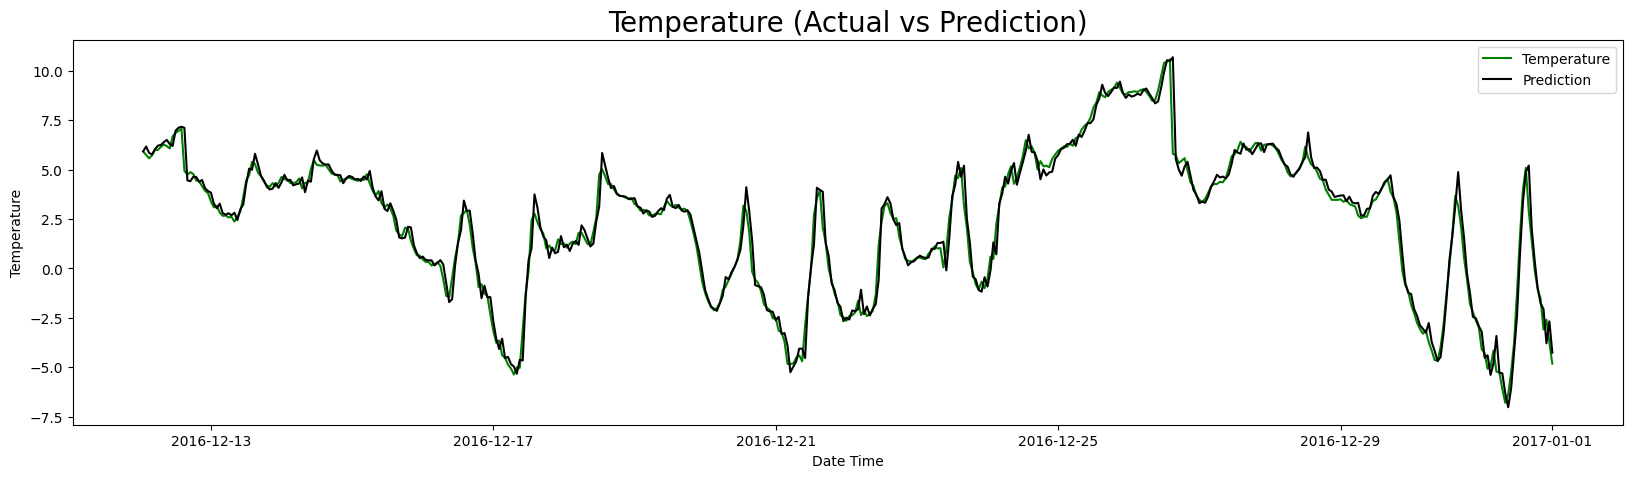

In [ ]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)
# Extract the actual and predicted values from df_result
y_true = df_result[-480:]['Temperature']
y_pred = df_result[-480:]['Prediction']

# Evaluate the model using the evaluation function
evaluate_model(y_true, y_pred)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.3572243790378173
Mean Squared Error (MSE):  0.3024335815485523
Root Mean Squared Error (RMSE):  0.549939616274871
Mean Absolute Percentage Error (MAPE):  36.212349764475


GRU


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay

# Define the GRU model
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(window_len, len(input_.columns)), return_sequences=True),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(1)
])

# Learning rate scheduler
num_epochs = 10
num_train_steps = len(train_gen) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)

gru_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
                  metrics=[tf.metrics.RootMeanSquaredError()])

# Print model summary
gru_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 128)           54528     
                                                                 
 re_lu_6 (ReLU)              (None, 24, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 91841 (358.75 KB)
Trainable params: 91841 (358.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)

gru_model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/10
3350/3350 [==============================] - 45s 12ms/step - loss: 4.9858 - root_mean_squared_error: 2.2329 - val_loss: 1.3448 - val_root_mean_squared_error: 1.1596
Epoch 2/10
3350/3350 [==============================] - 35s 11ms/step - loss: 1.2555 - root_mean_squared_error: 1.1205 - val_loss: 0.8118 - val_root_mean_squared_error: 0.9010
Epoch 3/10
3350/3350 [==============================] - 32s 9ms/step - loss: 0.8586 - root_mean_squared_error: 0.9266 - val_loss: 0.7557 - val_root_mean_squared_error: 0.8693
Epoch 4/10
3350/3350 [==============================] - 33s 10ms/step - loss: 0.7412 - root_mean_squared_error: 0.8610 - val_loss: 0.6830 - val_root_mean_squared_error: 0.8264
Epoch 5/10
3350/3350 [==============================] - 26s 8ms/step - loss: 0.6445 - root_mean_squared_error: 0.8028 - val_loss: 0.7035 - val_root_mean_squared_error: 0.8388
Epoch 6/10
3350/3350 [==============================] - 26s 8ms/step - loss: 0.5681 - root_mean_squared_error: 0.7537 - va

In [ ]:
# save model
gru_model.save('multi_gru_temperature.h5')

# load model
Gru_model = tf.keras.models.load_model('multi_gru_temperature.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pred2 = Gru_model.predict(test_gen).flatten()

437/437 [==============================] - 2s 3ms/step


In [ ]:
pred2

array([ 0.9275722 ,  0.94572276,  0.93465716, ..., -3.463339  ,
       -2.4392717 , -3.8326695 ], dtype=float32)

In [ ]:
df_result = X_test[window_len:].copy()
df_result['pred2'] =  pred2
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time','T (degC)','pred2']].set_axis(['Date Time', 'Temperature', 'Prediction'],axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63106,2016-12-03 21:00:00,0.87,0.927572
63107,2016-12-03 22:00:00,0.88,0.945723
63108,2016-12-03 23:00:00,0.93,0.934657
63109,2016-03-13 00:00:00,1.07,0.930573
63110,2016-03-13 01:00:00,1.07,1.169017


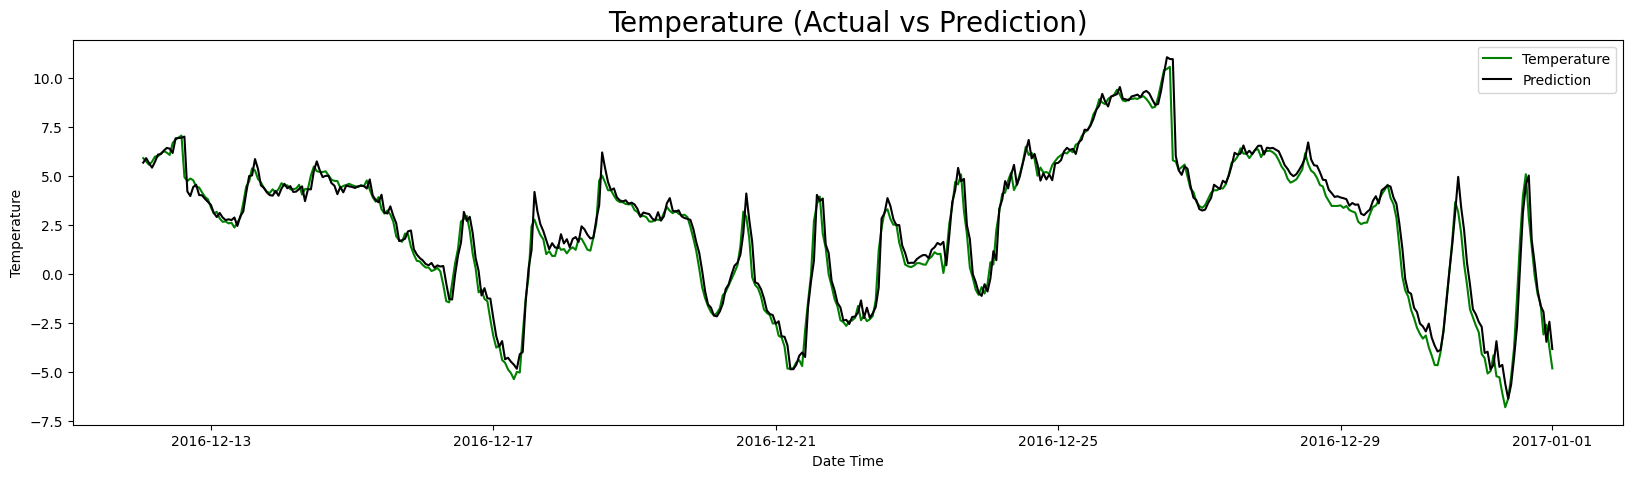

In [ ]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)
# Extract the actual and predicted values from df_result
y_true = df_result[-480:]['Temperature']
y_pred = df_result[-480:]['Prediction']

# Evaluate the model using the evaluation function
evaluate_model(y_true, y_pred)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.4259583759705226
Mean Squared Error (MSE):  0.38323208218905486
Root Mean Squared Error (RMSE):  0.6190574142913199
Mean Absolute Percentage Error (MAPE):  49.851025980427345


CNN

In [ ]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_len,len(input_.columns))),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

cnn_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
                  metrics=[tf.metrics.RootMeanSquaredError()])

# Print model summary
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 64)            2368      
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                32050     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                      

In [ ]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)

cnn_model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/10
3350/3350 [==============================] - 19s 6ms/step - loss: 1.5374 - root_mean_squared_error: 1.2399 - val_loss: 3027.9038 - val_root_mean_squared_error: 55.0264
Epoch 2/10
3350/3350 [==============================] - 22s 6ms/step - loss: 1.0822 - root_mean_squared_error: 1.0403 - val_loss: 1652.3469 - val_root_mean_squared_error: 40.6491
Epoch 3/10
3350/3350 [==============================] - 17s 5ms/step - loss: 0.8790 - root_mean_squared_error: 0.9376 - val_loss: 1176.4413 - val_root_mean_squared_error: 34.2993
Epoch 4/10
3350/3350 [==============================] - 20s 6ms/step - loss: 0.7674 - root_mean_squared_error: 0.8760 - val_loss: 817.8903 - val_root_mean_squared_error: 28.5988
Epoch 5/10
3350/3350 [==============================] - 17s 5ms/step - loss: 0.6825 - root_mean_squared_error: 0.8261 - val_loss: 873.4299 - val_root_mean_squared_error: 29.5538
Epoch 6/10
3350/3350 [==============================] - 16s 5ms/step - loss: 0.6096 - root_mean_squared_err

In [ ]:
# save model
cnn_model.save('multi_cnn_temperature.h5')

# load model
cnn_model = tf.keras.models.load_model('multi_cnn_temperature.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pred3 = cnn_model.predict(test_gen).flatten()

437/437 [==============================] - 1s 2ms/step


In [ ]:
df_result = X_test[window_len:].copy()
df_result['pred3'] =  pred3
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time','T (degC)','pred3']].set_axis(['Date Time', 'Temperature', 'Prediction'],axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63106,2016-12-03 21:00:00,0.87,0.802427
63107,2016-12-03 22:00:00,0.88,0.681628
63108,2016-12-03 23:00:00,0.93,0.770810
63109,2016-03-13 00:00:00,1.07,0.966079
63110,2016-03-13 01:00:00,1.07,1.144912


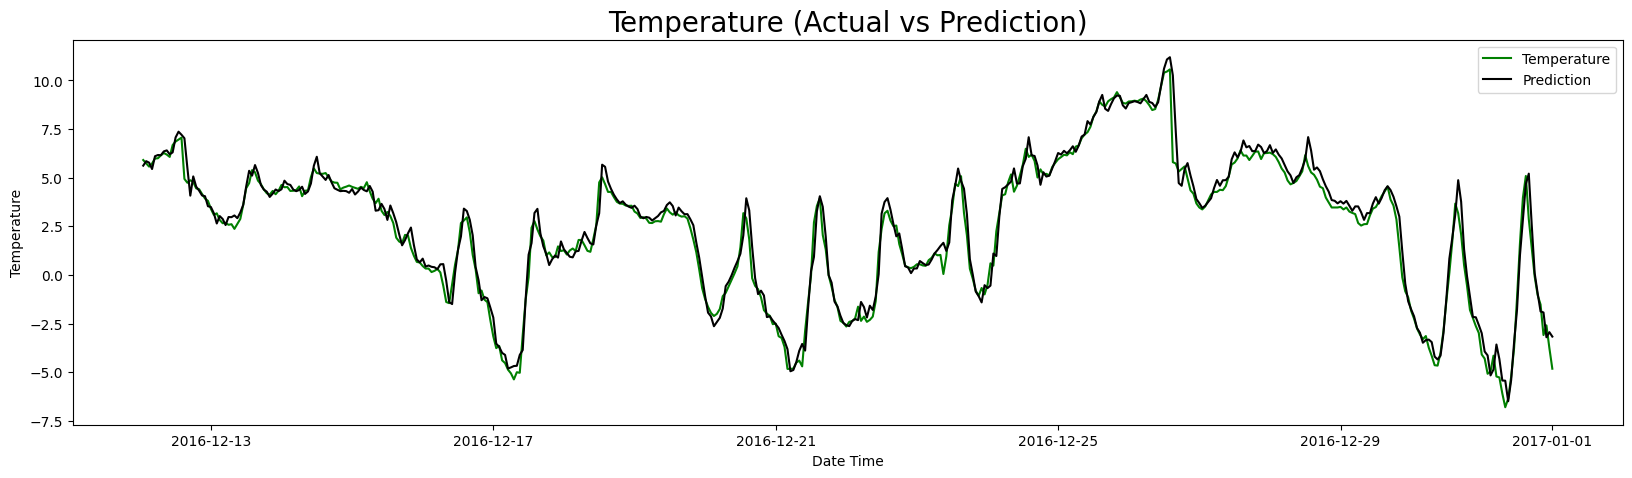

In [ ]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)
# Extract the actual and predicted values from df_result
y_true = df_result[-480:]['Temperature']
y_pred = df_result[-480:]['Prediction']

# Evaluate the model using the evaluation function
evaluate_model(y_true, y_pred)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.39857365599150457
Mean Squared Error (MSE):  0.3350742973008736
Root Mean Squared Error (RMSE):  0.578856024673557
Mean Absolute Percentage Error (MAPE):  35.79426598052367


TCN Multi


In [42]:
tcn_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(window_len, len(input_.columns))),
    TCN(nb_filters=64, kernel_size=2, dilations=[1, 2, 4], return_sequences=False),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
# learning rate scheduler
num_epochs = 10
num_train_steps = len(train_gen) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)
# Learning rate scheduler
tcn_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
                  metrics=[tf.metrics.RootMeanSquaredError()])

# Print model summary
tcn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_2 (TCN)                 (None, 64)                43712     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 44241 (172.82 KB)
Trainable params: 44241 (172.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 4,restore_best_weights=True,verbose=0)

tcn_model.fit(
    x=train_gen,
    validation_data=val_gen,
    shuffle=False,
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/10
3350/3350 [==============================] - 35s 8ms/step - loss: 4.2121 - root_mean_squared_error: 2.0523 - val_loss: 12216.2793 - val_root_mean_squared_error: 110.5273
Epoch 2/10
3350/3350 [==============================] - 37s 11ms/step - loss: 1.2149 - root_mean_squared_error: 1.1022 - val_loss: 8494.0732 - val_root_mean_squared_error: 92.1633
Epoch 3/10
3350/3350 [==============================] - 32s 9ms/step - loss: 0.8837 - root_mean_squared_error: 0.9401 - val_loss: 8634.2021 - val_root_mean_squared_error: 92.9204
Epoch 4/10
3350/3350 [==============================] - 31s 9ms/step - loss: 0.7006 - root_mean_squared_error: 0.8370 - val_loss: 6022.4072 - val_root_mean_squared_error: 77.6042
Epoch 5/10
3350/3350 [==============================] - 25s 7ms/step - loss: 0.6214 - root_mean_squared_error: 0.7883 - val_loss: 4658.7056 - val_root_mean_squared_error: 68.2547
Epoch 6/10
3350/3350 [==============================] - 25s 7ms/step - loss: 0.5755 - root_mean_square

In [51]:
# save model
tcn_model.save('multi_tcn_temperature.h5')

# load model
tcn_model = tf.keras.models.load_model('multi_tcn_temperature.h5')

In [47]:
pred4 = tcn_model.predict(test_gen).flatten()

437/437 [==============================] - 2s 3ms/step


In [48]:
df_result = X_test[window_len:].copy()
df_result['pred4'] =  pred4
df_result['Date Time'] = df['Date Time'][X_test.index[0]:].copy()
df_result = df_result[['Date Time','T (degC)','pred4']].set_axis(['Date Time', 'Temperature', 'Prediction'],axis=1)
df_result.head()

,Date Time,Temperature,Prediction
63106,2016-12-03 21:00:00,0.87,1.197831
63107,2016-12-03 22:00:00,0.88,1.109756
63108,2016-12-03 23:00:00,0.93,1.125537
63109,2016-03-13 00:00:00,1.07,1.005844
63110,2016-03-13 01:00:00,1.07,1.236316


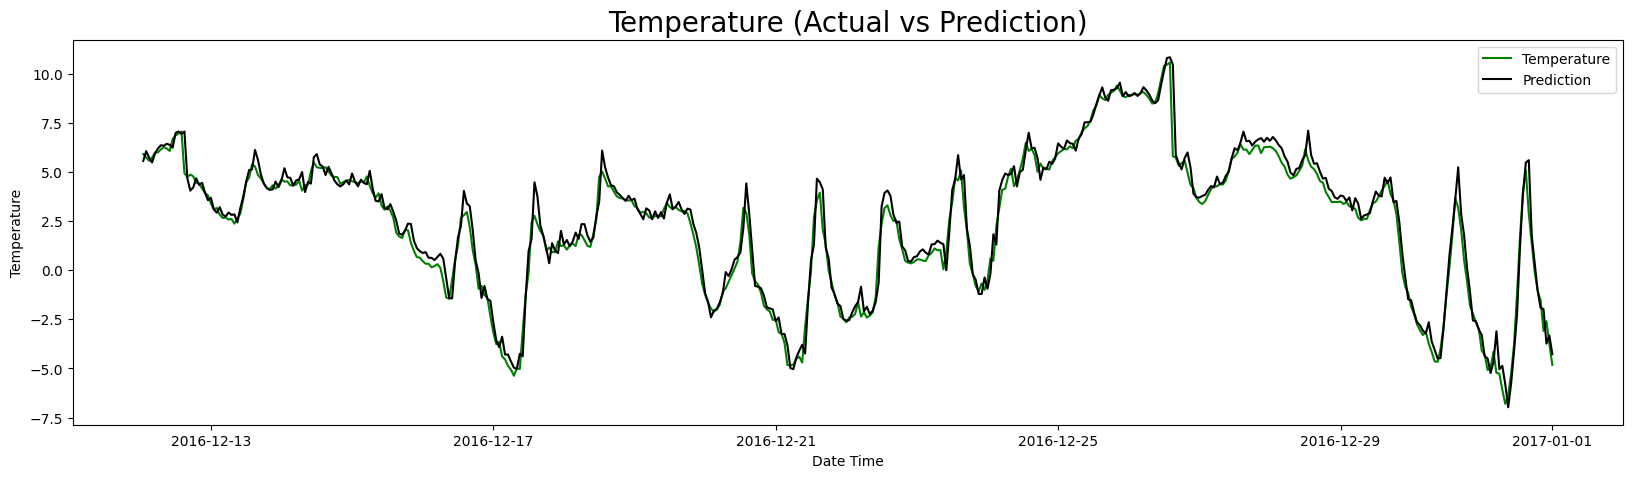

In [49]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_result[-480:], x='Date Time', y='Temperature', label='Temperature', color='green')
sns.lineplot(data=df_result[-480:], x='Date Time', y='Prediction', label='Prediction', color='black')
plt.title('Temperature (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def evaluate_model(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("This is based on the Test and actual")
    print("Mean Absolute Error (MAE): ", mae)
    print("Mean Squared Error (MSE): ", mse)
    print("Root Mean Squared Error (RMSE): ", rmse)
    print("Mean Absolute Percentage Error (MAPE): ", mape)
# Extract the actual and predicted values from df_result
y_true = df_result[-480:]['Temperature']
y_pred = df_result[-480:]['Prediction']

# Evaluate the model using the evaluation function
evaluate_model(y_true, y_pred)

This is based on the Test and actual
Mean Absolute Error (MAE):  0.42184437488019466
Mean Squared Error (MSE):  0.36786572222135344
Root Mean Squared Error (RMSE):  0.6065193502447828
Mean Absolute Percentage Error (MAPE):  45.714748671522656
